# Introduction to Weight Quantization
Reducing the size of Large Language Models with 8-bit quantization

Symmetric 8-bit quantization technique from scratch using the absmax method.

In [ ]:
import torch

def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X)) # usually formula is torch.max(torch.abs(X)) / 127 but it is used reversed so all formulas will be reversed

    print(f"Scale: {scale}")

    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

Asymmetric 8-bit quantization with a zero-point

Key Components:
- Scale: Controls how much each int8 step represents in float.
- Zero-point: Maps the smallest float value to a specific int8 value (shifts the distribution so 0 float maps to near 0 int8).

Why Use Zero-Point?
- Real-world data is not always centered around 0.
- Asymmetric quantization gives better range coverage for skewed distributions.

In [ ]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # Calculate scale
    scale = 255 / x_range # usually formula is x_range / 255 but it is used reversed so all formulas will be reversed

    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()

    print(f"Zero-point: {zeropoint}")
    print(f"Scale: {scale}")

    # Scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    # Dequantize
    X_dequant = (X_quant - zeropoint) / scale

    return X_quant.to(torch.int8), X_dequant

In [ ]:
# Sample input
X = torch.tensor([-2.5, -1.0, 0.0, 0.5, 1.5, 3.0], dtype=torch.float32)

# Apply quantization
X_quant, X_dequant = absmax_quantize(X)

# Print results
print("Original X:      ", X)
print("Quantized (int8):", X_quant)
print("Dequantized:     ", X_dequant)

Scale: 42.333335876464844
Original X:       tensor([-2.5000, -1.0000,  0.0000,  0.5000,  1.5000,  3.0000])
Quantized (int8): tensor([-106,  -42,    0,   21,   64,  127], dtype=torch.int8)
Dequantized:      tensor([-2.5039, -0.9921,  0.0000,  0.4961,  1.5118,  3.0000])


In [ ]:
# Sample input
X = torch.tensor([-2.5, -1.0, 0.0, 0.5, 1.5, 3.0], dtype=torch.float32)

# Apply quantization
X_quant, X_dequant = zeropoint_quantize(X)

# Print results
print("Original X:      ", X)
print("Quantized (int8):", X_quant)
print("Dequantized:     ", X_dequant)

Zero-point: -12.0
Scale: 46.3636360168457
Original X:       tensor([-2.5000, -1.0000,  0.0000,  0.5000,  1.5000,  3.0000])
Quantized (int8): tensor([-128,  -58,  -12,   11,   58,  127], dtype=torch.int8)
Dequantized:      tensor([-2.5020, -0.9922,  0.0000,  0.4961,  1.5098,  2.9980])


In [ ]:
!pip install -q bitsandbytes>=0.39.0
!pip install -q git+https://github.com/huggingface/accelerate.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

# Set device to CPU for now
device = 'cpu'

# Load model and tokenizer
model_id = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Print model size
print(f"Model size: {model.get_memory_footprint():,} bytes")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model size: 510,342,192 bytes


In [ ]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [ ]:
# Extract weights of the first layer
weights = model.transformer.h[0].attn.c_attn.weight.data
print("Original weights:")
print(weights)

# Quantize layer using absmax quantization
weights_abs_quant, _ = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

# Quantize layer using absmax quantization
weights_zp_quant, _ = zeropoint_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]])
Scale: 44.66115951538086

Absmax quantized weights:
tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -1],
        ...,
        [-12,  -1,   9,  ...,   0,  -2,   1],
        [  7,  10,   5,  ...,   1,  -2,  -2],
        [-18,  -9, -11,  ...,   0,   0,   1]], dtype=torch.int8)
Zero-point: 1.0
Scale: 45.218666076660156

Zero-point quantized weights:
tensor([[-20, -11,  -3,  ...,   3,  -2,   2],
        [  5,   8,  12,  ...,  -1,   0,   0],
        [  1,   4,  18,

In [ ]:
for name, param in model.named_parameters():
    print(f"{name:40} {tuple(param.data.shape)}")

transformer.wte.weight                   (50257, 768)
transformer.wpe.weight                   (1024, 768)
transformer.h.0.ln_1.weight              (768,)
transformer.h.0.ln_1.bias                (768,)
transformer.h.0.attn.c_attn.weight       (768, 2304)
transformer.h.0.attn.c_attn.bias         (2304,)
transformer.h.0.attn.c_proj.weight       (768, 768)
transformer.h.0.attn.c_proj.bias         (768,)
transformer.h.0.ln_2.weight              (768,)
transformer.h.0.ln_2.bias                (768,)
transformer.h.0.mlp.c_fc.weight          (768, 3072)
transformer.h.0.mlp.c_fc.bias            (3072,)
transformer.h.0.mlp.c_proj.weight        (3072, 768)
transformer.h.0.mlp.c_proj.bias          (768,)
transformer.h.1.ln_1.weight              (768,)
transformer.h.1.ln_1.bias                (768,)
transformer.h.1.attn.c_attn.weight       (768, 2304)
transformer.h.1.attn.c_attn.bias         (2304,)
transformer.h.1.attn.c_proj.weight       (768, 768)
transformer.h.1.attn.c_proj.bias         (768,

In [ ]:
import numpy as np
from copy import deepcopy

# Store original weights
weights = [param.data.clone() for param in model.parameters()]
# In the code you shared, the quantization is applied in a layer-wise fashion — not vector-wise.
# param.data refers to the entire weight tensor of a layer (e.g., [2304, 768])

# Create model to quantize
model_abs = deepcopy(model)

# Quantize all model weights
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

# Create model to quantize
model_zp = deepcopy(model)

# Quantize all model weights
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = zeropoint_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

Scale: 71.14222717285156
Scale: 27.985197067260742
Scale: 502.63836669921875
Scale: 490.569091796875
Scale: 44.66115951538086
Scale: 94.98343658447266
Scale: 38.28600311279297
Scale: 47.31010818481445
Scale: 84.04837036132812
Scale: 171.76515197753906
Scale: 27.682598114013672
Scale: 170.2033233642578
Scale: 20.6730899810791
Scale: 85.84783172607422
Scale: 193.79421997070312
Scale: 191.1161346435547
Scale: 102.56119537353516
Scale: 65.48210906982422
Scale: 26.87126922607422
Scale: 101.54319763183594
Scale: 280.7899169921875
Scale: 216.49801635742188
Scale: 55.47749328613281
Scale: 193.51412963867188
Scale: 9.245630264282227
Scale: 79.65491485595703
Scale: 134.48802185058594
Scale: 116.13150024414062
Scale: 75.71174621582031
Scale: 86.80807495117188
Scale: 55.32450485229492
Scale: 246.6670684814453
Scale: 174.06483459472656
Scale: 196.29461669921875
Scale: 12.03129768371582
Scale: 73.34761810302734
Scale: 8.428421020507812
Scale: 81.01248168945312
Scale: 165.4356689453125
Scale: 73.1004

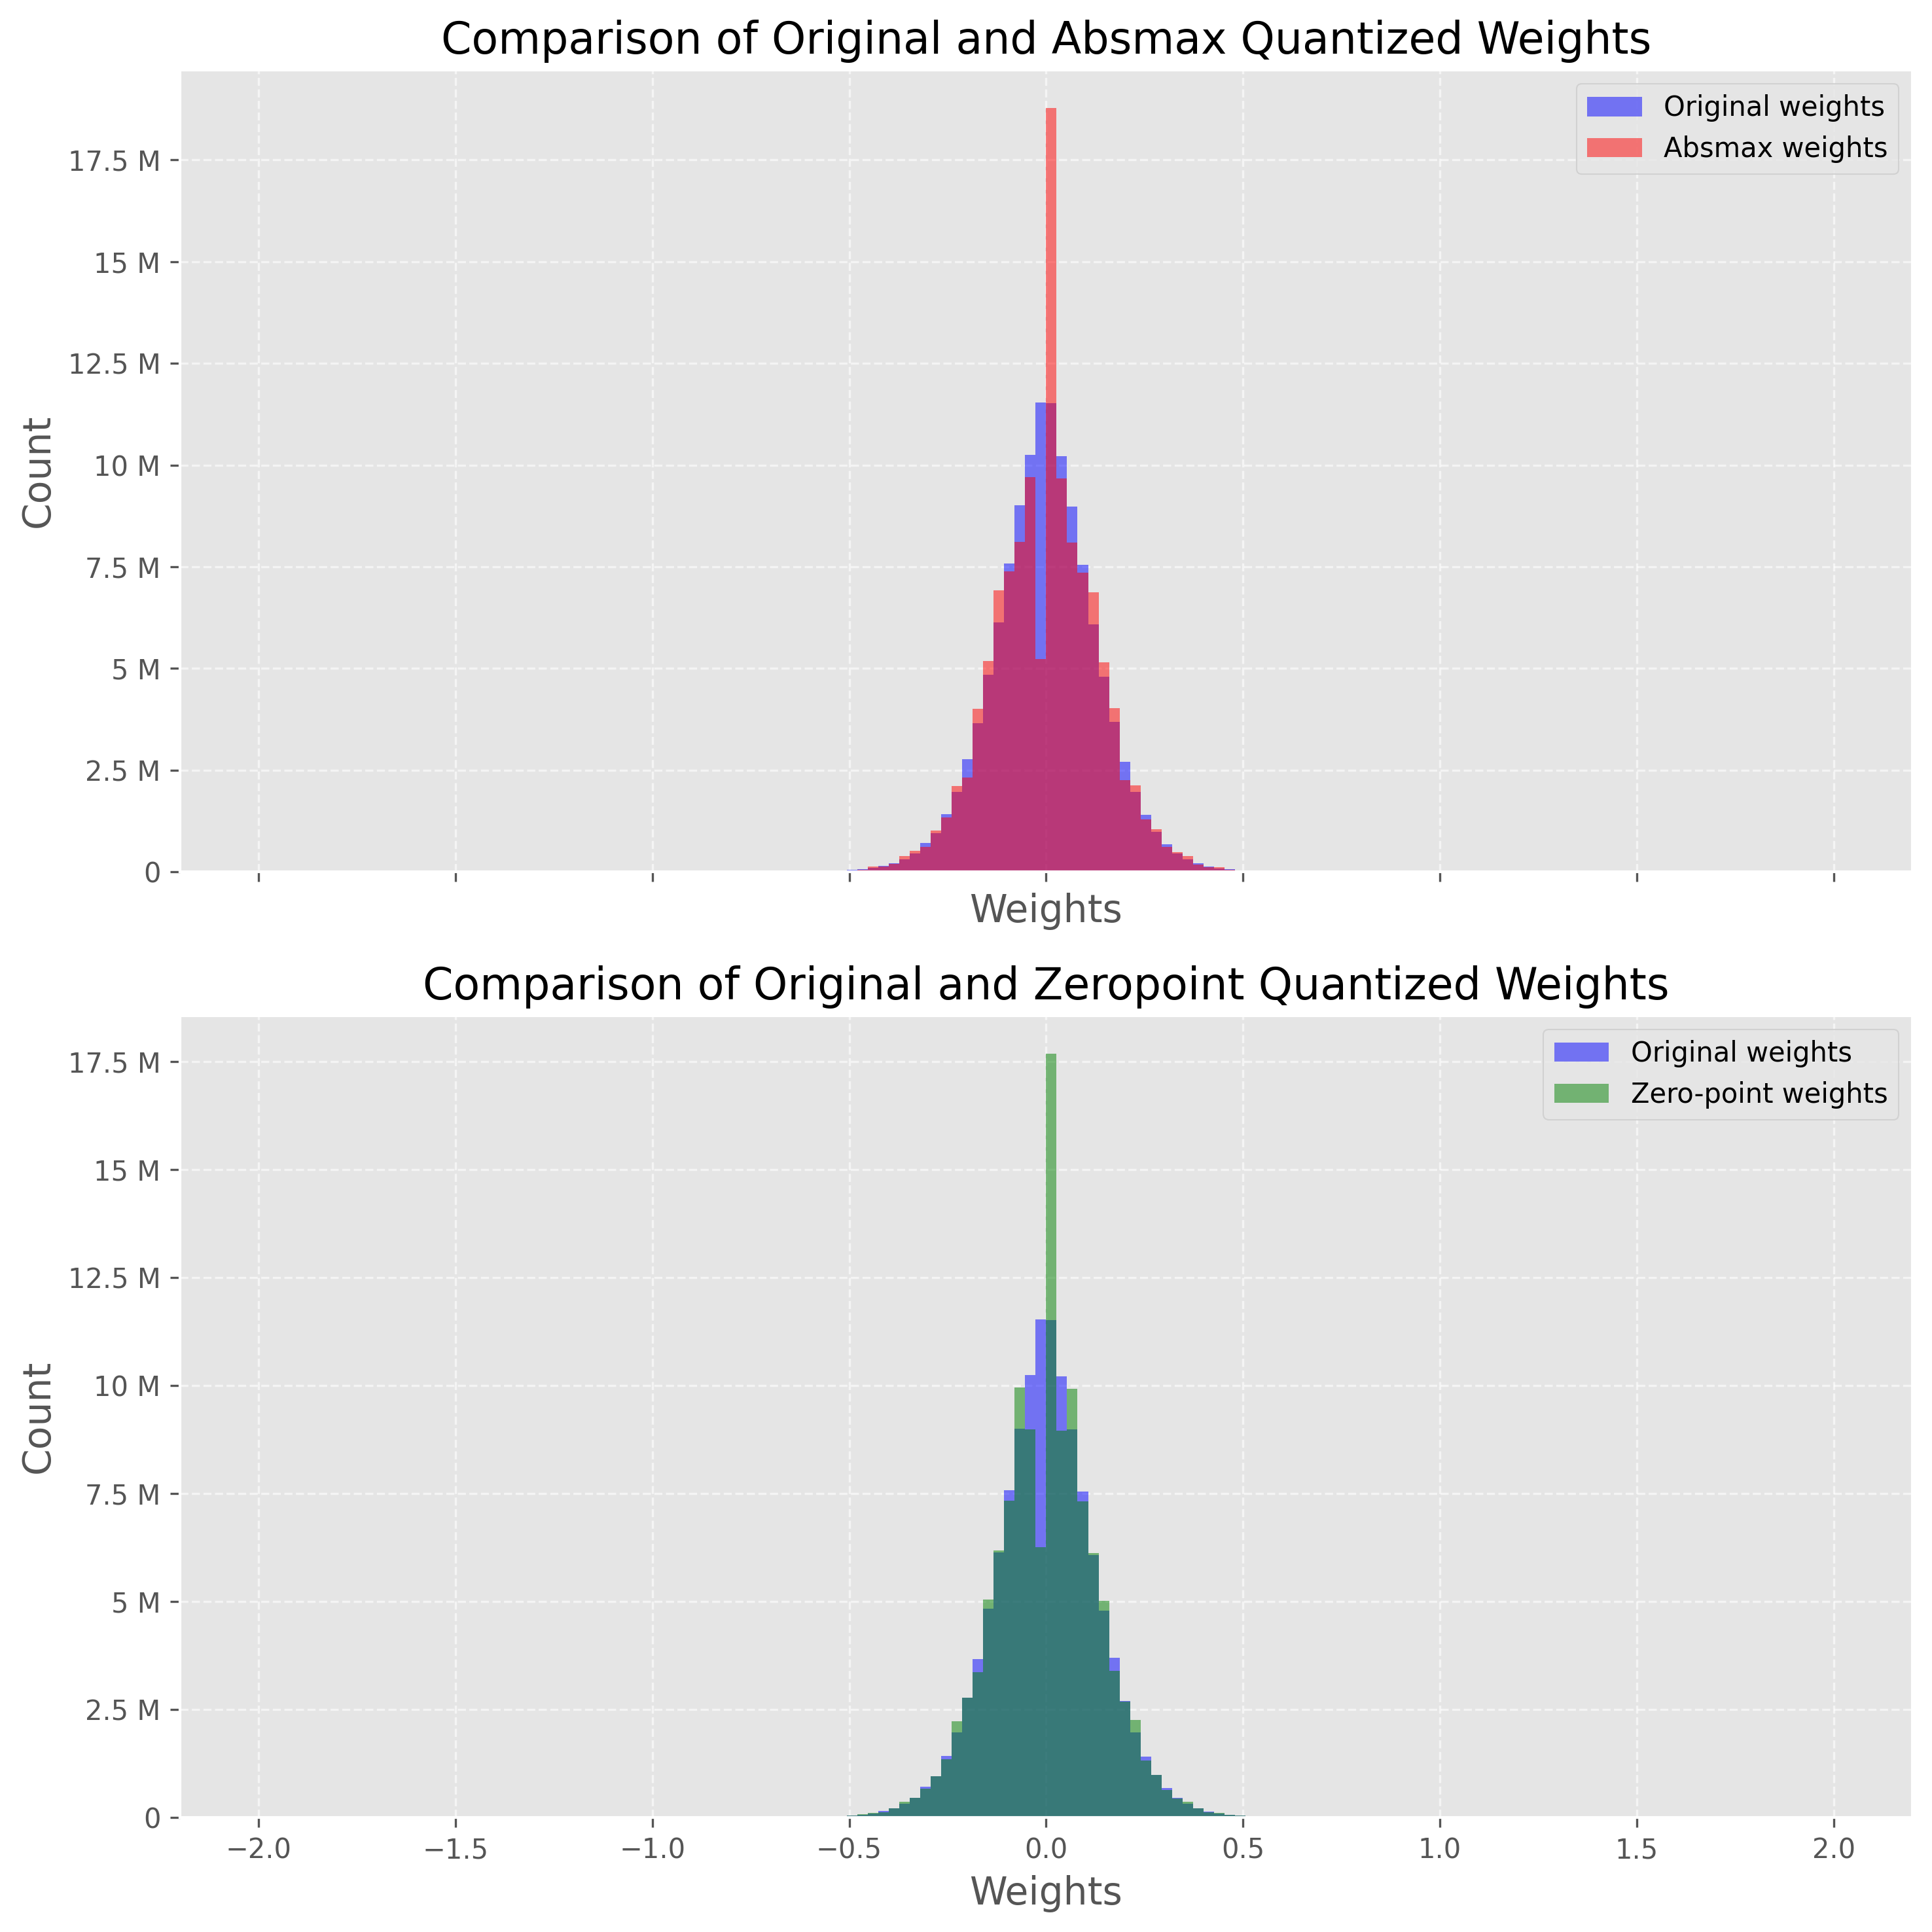

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
weights_zp = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(2, figsize=(10,10), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))

# Plot the histograms for original and absmax weights
axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(weights_zp, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()


In [ ]:
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have a dream")
absmax_text   = generate_text(model_abs, "I have a dream")
zp_text       = generate_text(model_zp, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
I have a dream," he said. "You have a dream. The dream of a great guy. You dream that you'll be one day an NFL superstar. You dream that you'll be one day a quarterback in the NFL. You dream that
--------------------------------------------------
Absmax model:
I have a dream on my hands, to have all of America become better off." It's only a dream, but it's worth it. This was an awesome time to be alive! I was really, really lucky here, I could have been
--------------------------------------------------
Zeropoint model:
I have a dream for you. We both love you.


Thank You!

I love you,

you're the coolest.


### What is Perplexity?

**Perplexity** is a common evaluation metric for language models. It measures how well a model predicts a sequence of tokens. Lower perplexity means the model is more confident and accurate in its predictions.

---


### Interpretation Guide

| Perplexity Score | Interpretation                     |
|------------------|-------------------------------------|
| ≈ 1              | Perfect prediction (very rare)      |
| 10–50            | Good model performance              |
| 100+             | Model is struggling or off-domain   |

---

### How It's Computed in Code

- We generate the text first then we pass the same generated text as input as well as both the target (for self-supervised loss).
- The model computes the average negative log-likelihood (cross-entropy loss).
- We take the exponential of that loss to get the perplexity:


In [ ]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, absmax_text)
ppl_zp  = calculate_perplexity(model_zp, zp_text)

print(f"Original perplexity: {ppl.item():.2f}")
print(f"Absmax perplexity:   {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity: 7.59
Absmax perplexity:   21.52
Zeropoint perplexity: 15.12


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_int8 = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map='auto',
                                             load_in_8bit=True,
                                             )
print(f"Model size: {model_int8.get_memory_footprint():,} bytes")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Model size: 176,527,896 bytes


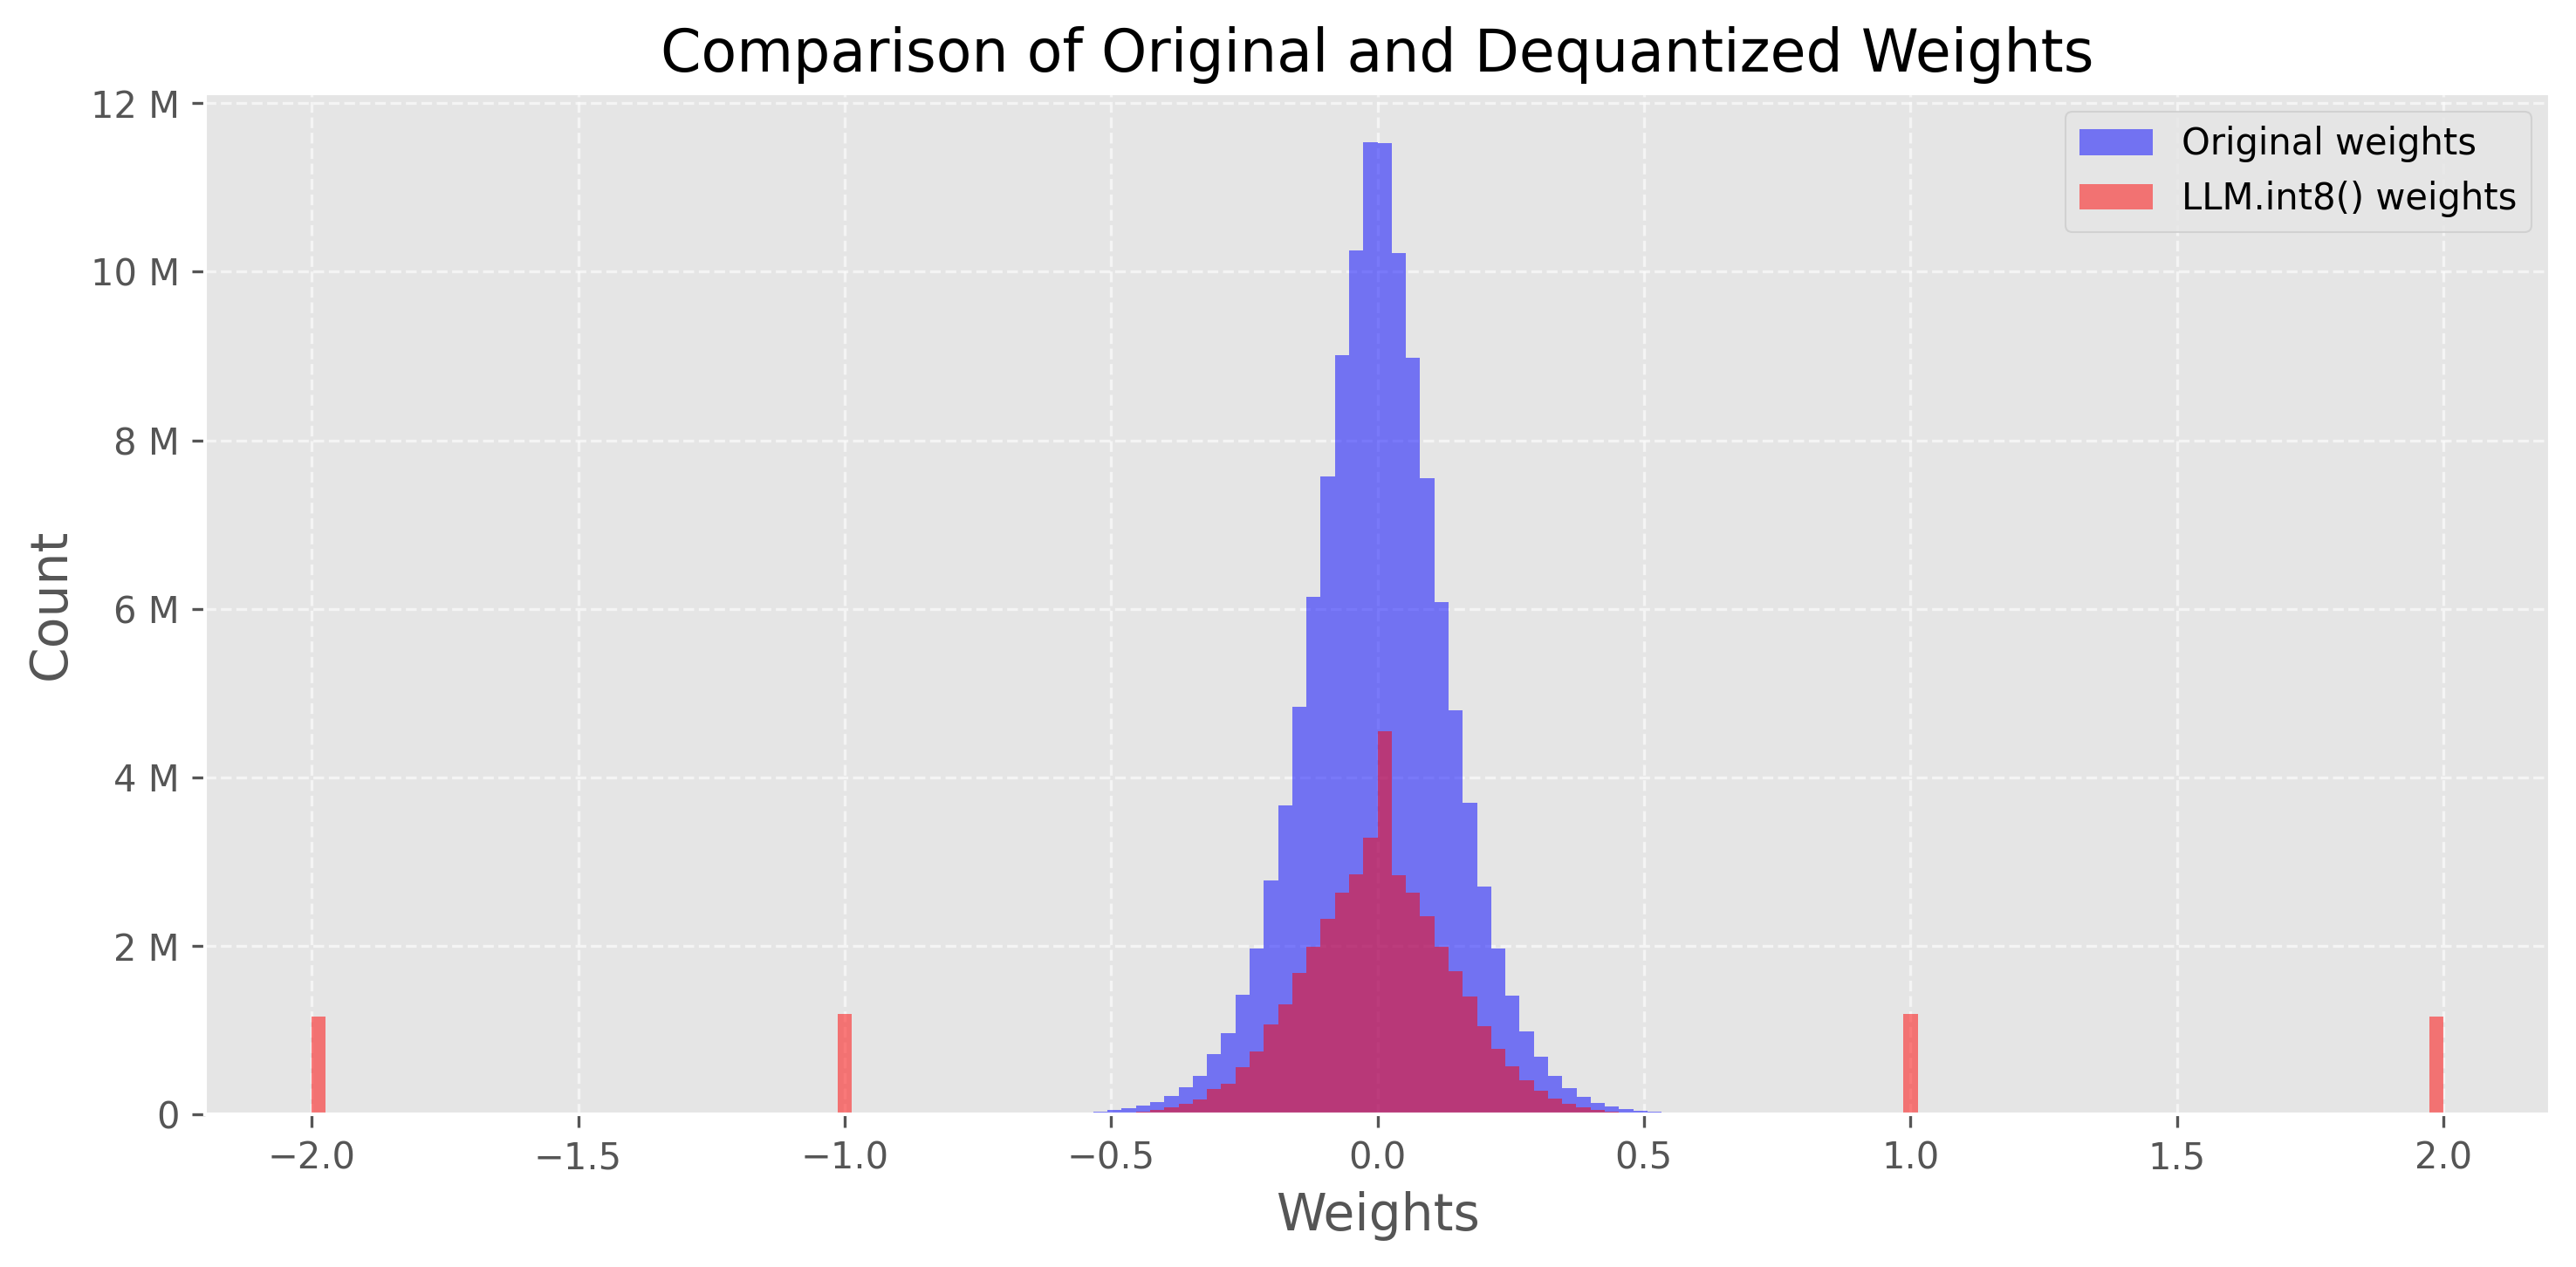

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights_int8 = [param.data.clone() for param in model_int8.parameters()]
weights_int8 = np.concatenate([t.cpu().numpy().flatten() for t in weights_int8])

# Set background style
plt.style.use('ggplot')

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

# Plot the histograms
ax.hist(weights, bins=150, alpha=0.5, label='Original weights',
        color='blue', range=(-2, 2))
ax.hist(weights_int8, bins=150, alpha=0.5, label='LLM.int8() weights',
        color='red', range=(-2, 2))

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
ax.legend()

# Add title and labels
ax.set_title('Comparison of Original and Dequantized Weights', fontsize=16)
ax.set_xlabel('Weights', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

In [ ]:
# Generate text with quantized model
text_int8 = generate_text(model_int8, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

Original model:
I have a dream," he said. "You have a dream. The dream of a great guy. You dream that you'll be one day an NFL superstar. You dream that you'll be one day a quarterback in the NFL. You dream that
--------------------------------------------------
LLM.int8() model:
I have a dream. I don't know what will happen, but you have to try. You have to look for something that you are interested in. It's always hard to look for when you are a rookie, but the only thing that I


In [ ]:
print(f"Perplexity (original):   {ppl.item():.2f}")

ppl = calculate_perplexity(model_int8, text_int8)
print(f"Perplexity (LLM.int8()): {ppl.item():.2f}")

Perplexity (original):   7.59
Perplexity (LLM.int8()): 10.60


## Reference
Base code is created by [@maximelabonne](https://twitter.com/maximelabonne).

Companion notebook to execute the code from the following article: https://mlabonne.github.io/blog/intro_weight_quantization/